## Group ID
DML Group 72


## Group Members
1. Ravindra Kumar Tholiya - 2023AA05124
2. Shivam Sahil - 2023AA05663
3. Jahnavi Gali - 2023AA05684
4. Anurag Anand - 2023AA05475

In [ ]:
# Install necessary libraries
!pip install --upgrade kafka-python
!pip install keras
!pip install kafka-python tensorflow numpy
!python --version

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.1/252.1 kB 5.9 MB/s eta 0:00:00
Python 3.11.11


In [ ]:
# Necessary Imports

import json
import time
import random
import threading
import uuid
import datetime

from kafka import KafkaProducer, KafkaConsumer

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
import os
import socket
from kafka.admin import KafkaAdminClient, NewTopic
from kafka.errors import TopicAlreadyExistsError
import matplotlib.pyplot as plt
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

def get_path(path):
  base_path = r'drive/MyDrive/temp_db/2909'

  if not os.path.exists(base_path):
    os.makedirs(base_path)

  return os.path.join(base_path, path)

Mounted at /content/drive


#### Kafka Broker Access

Since Colab needs to connect to an online Kafka Broker, we have generated one from [here](https://aiven.io/).

For preventing endpoint abuse, the secrets are stored in Drive environment. If you're interested in running please update the following path variables in google Drive:
```text
kafka_secrets/access_key_kafka.key
kafka_secrets/ca_cert_kafka.pem
kafka_secrets/access_certificate_kafka.pem
KAFKA_SERVICE_URL -> kafka-80951e9-kafka-example.g.aivencloud.com:18249
```

In [ ]:
service_url = 'kafka-80951e9-kafka-example.g.aivencloud.com'
port = 18249
broker_url = f'{service_url}:{port}'

input_topic = "input-data"
pred_topic = 'predictions'

# Other configurations
producer_interval = 1  # seconds between messages

print('Global configuration set.')

print('Kafka configuration set:')
print(f"Broker: {broker_url}")
print(f"Input Topic: {input_topic}")
print(f"Prediction Topic: {pred_topic}")

cafile = get_path(r'kafka_secrets/ca_cert_kafka.pem')
certfile = get_path(r'kafka_secrets/access_certificate_kafka.cert')
keyfile = get_path(r'kafka_secrets/access_key_kafka.key')


if not os.path.exists(cafile) or not os.path.exists(certfile) or not os.path.exists(keyfile):
  raise ValueError('Access Key/Access Certificate/ CA Certificate is necessary for making connection to Kafka Cloud before procceeding')

print(f'Kafka broker would be trying to connect to {broker_url}. If you haven\'t already added KAFKA_BROKER_ACCESS_KEY, KAFKA_BROKER_ACCESS_CERTIFICATE, and KAFKA_BROKER_CA_CERTIFICATE in colab secretsplease make sure to add those in order to avoid unexpected connection errors.')

Global configuration set.
Kafka configuration set:
Broker: kafka-80951e9-kafka-example.g.aivencloud.com:18249
Input Topic: input-data
Prediction Topic: predictions
Kafka broker would be trying to connect to kafka-80951e9-kafka-example.g.aivencloud.com:18249. If you haven't already added KAFKA_BROKER_ACCESS_KEY, KAFKA_BROKER_ACCESS_CERTIFICATE, and KAFKA_BROKER_CA_CERTIFICATE in colab secretsplease make sure to add those in order to avoid unexpected connection errors.


In [ ]:
def test_kafka_connection(host, port):
    try:
        with socket.create_connection((host, port), timeout=5):
            print(f"✅ Successfully connected to {host}:{port}")
            return True
    except Exception as e:
        print(f"❌ Unable to connect to {host}:{port} - {e}")
        return False

def create_new_topics(admin_client, topics):
  try:
    print("Deleting topics if already exists:", topics)
    admin_client.delete_topics(topics=topics)
    print("Waiting for topics to be deleted...")
    time.sleep(5)
    topic_list = [NewTopic(name=topic_name, num_partitions=1, replication_factor=1) for topic_name in topics]
    admin_client.create_topics(new_topics=topic_list, validate_only=False)
    print("✅ Topics cleared and recreated successfully.")
  except Exception as e:
    print(f"⚠️ Error creating topics: {e}")

def check_kafka_status(broker, ssl_cafile=None, ssl_certfile=None, ssl_keyfile=None):
    try:
      if ssl_cafile and ssl_certfile and ssl_keyfile:
          admin_client = KafkaAdminClient(
              bootstrap_servers=broker,
              security_protocol="SSL",
              ssl_cafile=ssl_cafile,
              ssl_certfile=ssl_certfile,
              ssl_keyfile=ssl_keyfile,
              request_timeout_ms=5000
          )
      else:
        admin_client = KafkaAdminClient(
            bootstrap_servers=broker,
            request_timeout_ms=5000
        )
      topics = admin_client.list_topics()
      print(f"✅ Kafka is running. Available topics: {topics}")
      create_new_topics(admin_client = admin_client, topics = [input_topic, pred_topic])
    except Exception as e:
      print(f"❌ Kafka is NOT running or unreachable: {e}")
    finally:
      admin_client.close()

In [ ]:
test_kafka_connection(service_url, port)
paths = {
    "CA Certificate": cafile,
    "Client Certificate": certfile,
    "Client Key": keyfile
}

for name, path in paths.items():
    if os.path.exists(path):
        print(f"✅ {name} exists at: {path}")
    else:
        print(f"❌ {name} is missing at: {path}")

check_kafka_status(broker = broker_url, ssl_cafile = cafile, ssl_certfile = certfile, ssl_keyfile = keyfile)

✅ Successfully connected to kafka-80951e9-kafka-example.g.aivencloud.com:18249
✅ CA Certificate exists at: drive/MyDrive/temp_db/2909/kafka_secrets/ca_cert_kafka.pem
✅ Client Certificate exists at: drive/MyDrive/temp_db/2909/kafka_secrets/access_certificate_kafka.cert
✅ Client Key exists at: drive/MyDrive/temp_db/2909/kafka_secrets/access_key_kafka.key
✅ Kafka is running. Available topics: ['predictions', 'input-data', '__consumer_offsets']
Deleting topics if already exists: ['input-data', 'predictions']
Waiting for topics to be deleted...
✅ Topics cleared and recreated successfully.


In [ ]:
# Simulate training data

def train_model():
  group_number = 72
  np.random.seed(group_number)
  prices = np.linspace(100, 200, num=1000)  # simulated prices
  noise = np.random.normal(0, 2, prices.shape)
  next_day_prices = prices + noise  # next day prices with noise

  X = prices.reshape(-1, 1)
  y = next_day_prices.reshape(-1, 1)

  print('Training data created.')

  # Build a simple neural network model
  model = Sequential([
      Input(shape=(1,)),
      Dense(64, activation='relu'),
      Dense(32, activation='relu'),
      Dense(1)
  ])

  model.compile(optimizer='adam', loss='mean_squared_error')

  print('Training the model...')
  model.fit(X, y, epochs=50, batch_size=32, verbose=0)
  print('Model training complete.')

  # Save the trained model to disk so that the consumer can load it
  model.save(get_path('stock_model.keras'))
  print('Model saved as stock_model.keras')

## Producer Implementation

The producer simulates streaming input data to the Kafka topic `input-data`.

Each message contains:

- A unique identifier (`id`)
- Input features (here, the current price)
- A timestamp

For demo purposes, the producer will send 10 messages with a delay.

In [ ]:
message_limit = 50

# Global list to store results for visualization
results_list = []

def create_message(price):
    # Compute a true next day price using a similar noise model as training.
    true_next_day = price + random.gauss(0, 2)
    return {
        'id': str(uuid.uuid4()),
        'features': {'price': price},
        'timestamp': datetime.datetime.utcnow().isoformat(),
        'true_next_day_price': true_next_day
    }

In [ ]:
# Simulate Price in a very random Fashion similar to stock market
def simulate_price(previous_price, mu=0.0002, sigma=0.01, dt=1):
    return previous_price * math.exp((mu - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * random.gauss(0, 1))

In [ ]:
def start_producer():
    producer = KafkaProducer(
        bootstrap_servers=[broker_url],
        security_protocol="SSL",
        ssl_cafile=cafile,
        ssl_certfile=certfile,
        ssl_keyfile=keyfile,
        value_serializer=lambda v: json.dumps(v).encode('utf-8')
    )
    message_count = 0
    price = 150
    try:
        while message_count < message_limit:
            price = simulate_price(price)
            data = create_message(price)
            producer.send(input_topic, value=data)
            print('Produced:', data)
            time.sleep(producer_interval)
            message_count += 1
    except KeyboardInterrupt:
        print("Producer stopped.")
    finally:
        producer.flush()
        producer.close()

In [ ]:
def plot_accuracy(results):
    # Extract true and predicted values and compute MSE
    true_vals = np.array([r['true'] for r in results])
    pred_vals = np.array([r['predicted'] for r in results])
    mse = np.mean((true_vals - pred_vals) ** 2)

    plt.figure(figsize=(8,6))
    plt.scatter(true_vals, pred_vals, label="Predictions")
    # Plot the ideal (perfect prediction) line
    min_val = min(true_vals.min(), pred_vals.min())
    max_val = max(true_vals.max(), pred_vals.max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="Ideal")
    plt.xlabel("True Next Day Price")
    plt.ylabel("Predicted Next Day Price")
    plt.title(f"Prediction Accuracy (MSE: {mse:.2f})")
    plt.legend()
    plt.show()

## Consumer Implementation with Neural Network Prediction

The consumer listens to the `input-data` topic, preprocesses incoming messages, and uses the saved neural network model to predict the next day's price.

After prediction, the consumer publishes the result (which includes the original input, the predicted value, and a prediction timestamp) to the `predictions` topic.

In [ ]:
def start_consumer():
    # Load the trained model (ensure filename matches producer save)
    model = tf.keras.models.load_model(get_path("stock_model.keras"))
    print("Loaded model for predictions.")

    consumer = KafkaConsumer(
        input_topic,
        bootstrap_servers=[broker_url],
        auto_offset_reset='earliest',
        group_id='consumer-group-1',
        security_protocol="SSL",
        ssl_cafile=cafile,
        ssl_certfile=certfile,
        ssl_keyfile=keyfile,
        value_deserializer=lambda m: json.loads(m.decode('utf-8')),
        consumer_timeout_ms=10000  # stop after 10 seconds with no new messages
    )

    producer = KafkaProducer(
        bootstrap_servers=[broker_url],
        security_protocol="SSL",
        ssl_cafile=cafile,
        ssl_certfile=certfile,
        ssl_keyfile=keyfile,
        value_serializer=lambda v: json.dumps(v).encode('utf-8')
    )

    message_count = 0
    try:
        for msg in consumer:
            data = msg.value
            print("Received message type:", type(data), data)
            if isinstance(data, dict) and isinstance(data.get('features'), dict):
                price = data['features']['price']
                input_array = np.array([[price]])

                # Predict the next day price using the model
                pred = model.predict(input_array)
                prediction = pred[0, 0]

                result = {
                    'id': data['id'],
                    'original_price': price,
                    'predicted_next_day_price': float(prediction),
                    'prediction_timestamp': datetime.datetime.utcnow().isoformat()
                }

                # Publish the prediction
                producer.send(pred_topic, value=result)
                print('Consumed and Predicted:', result)

                # Save the true and predicted values for later visualization
                results_list.append({
                    'true': data['true_next_day_price'],
                    'predicted': float(prediction)
                })

                message_count += 1
                if message_count >= message_limit:
                    break
            else:
                print("Unexpected message format:", data)
    except KeyboardInterrupt:
        print("Consumer stopped.")
    finally:
        consumer.close()
        producer.flush()
        producer.close()

    # After consuming 10 messages, plot the accuracy and then exit the program.
    plot_accuracy(results_list)
    import sys
    sys.exit(0)

Producer and Consumer threads started. Press Ctrl+C to stop.
Produced: {'id': 'c8da1651-5cbe-428c-b9d9-fc7d12d2f392', 'features': {'price': 149.31339679024973}, 'timestamp': '2025-03-14T14:12:30.588526', 'true_next_day_price': 147.87614794956832}
Loaded model for predictions.
Produced: {'id': '3893662f-6701-432f-a5ca-cbe671abe545', 'features': {'price': 149.60973427614744}, 'timestamp': '2025-03-14T14:12:31.710676', 'true_next_day_price': 146.70473642874276}
Produced: {'id': 'eb8770a2-8301-42be-9033-0fc88995cd36', 'features': {'price': 149.92774461808483}, 'timestamp': '2025-03-14T14:12:32.711234', 'true_next_day_price': 151.08728406148887}
Produced: {'id': 'f1b6ebcf-4875-4242-bb89-3bb0394c019b', 'features': {'price': 150.68800301843578}, 'timestamp': '2025-03-14T14:12:33.711864', 'true_next_day_price': 149.55436972241594}
Produced: {'id': '8496e90f-674d-4efb-8db2-81fc3c84fb71', 'features': {'price': 150.3529304514758}, 'timestamp': '2025-03-14T14:12:34.713027', 'true_next_day_price': 

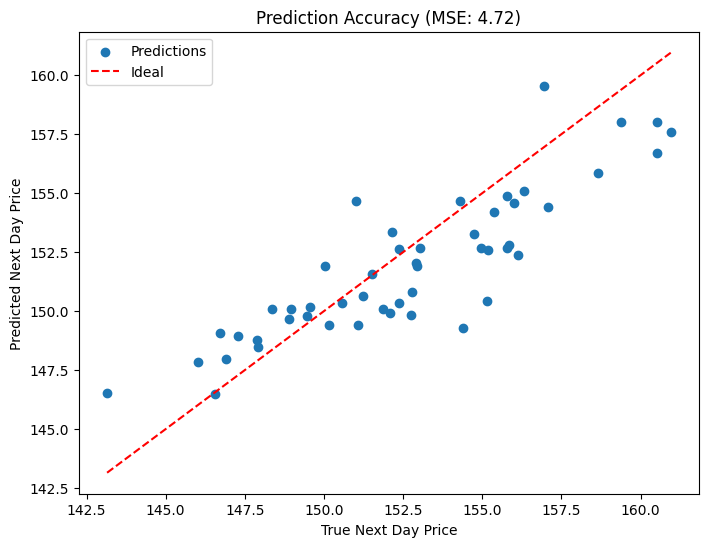

Stopping threads...


In [ ]:
if not os.path.exists(get_path('stock_model.keras')):
  train_model()
# Start producer and consumer in separate daemon threads
producer_thread = threading.Thread(target=start_producer, daemon=True)
consumer_thread = threading.Thread(target=start_consumer, daemon=True)

producer_thread.start()
consumer_thread.start()

print('Producer and Consumer threads started. Press Ctrl+C to stop.')

# Keep the notebook running
try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print('Stopping threads...')

In [ ]:
# Install necessary packages
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Copy the notebook to the current directory
!cp 'drive/My Drive/Colab Notebooks/DML_Assignment2_Group72.ipynb' ./

# Convert the notebook to PDF while keeping the code and output
!jupyter nbconvert --to pdf "DML_Assignment2_Group72.ipynb"


# Download the generated PDF
from google.colab import files
files.download('DML_Assignment2_Group72.pdf')

Selecting previously unselected package texlive-plain-generic.
Preparing to unpack .../56-texlive-plain-generic_2021.20220204-1_all.deb ...
Unpacking texlive-plain-generic (2021.20220204-1) ...
Selecting previously unselected package tipa.
Preparing to unpack .../57-tipa_2%3a1.3-21_all.deb ...
Unpacking tipa (2:1.3-21) ...
Selecting previously unselected package texlive-xetex.
Preparing to unpack .../58-texlive-xetex_2021.20220204-1_all.deb ...
Unpacking texlive-xetex (2021.20220204-1) ...
Setting up fonts-lato (2.0-2.1) ...
Setting up fonts-noto-mono (20201225-1build1) ...
Setting up libwoff1:amd64 (1.0.2-1build4) ...
Setting up libtexlua53:amd64 (2021.20210626.59705-1ubuntu0.2) ...
Setting up libijs-0.35:amd64 (0.35-15build2) ...
Setting up libtexluajit2:amd64 (2021.20210626.59705-1ubuntu0.2) ...
Setting up libfontbox-java (1:1.8.16-2) ...
Setting up rubygems-integration (1.18) ...
Setting up libzzip-0-13:amd64 (0.13.72+dfsg.1-1.1) ...
Setting up fonts-urw-base35 (20200910-1) ...
Set

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>